# Tutorial 3: Computing Unwindowed Power Spectra from BOSS DR12

In this tutorial, we will use PolyBin3D to estimate the power spectra of a section of the BOSS DR12 dataset. We will compute both the standard window-convolved and new unwindowed spectra, and discuss various choices of weighting schemes. Much of the data-handling routines in this section are borrowed from the [nbodykit cookbook](https://nbodykit.readthedocs.io/en/latest/cookbook/index.html). The PolyBin3D code is simple to use, but there's several preliminaries to get through before we can use it (i.e. building the data and the analysis mask). To avoid having to run this code on a cluster, we'll focus on the smallest BOSS data patch, and compute spectra at comparatively low $k$.

### Preliminaries

We start by importing the packages we'll need, as well as defining some useful plotting functions.

In [1]:
%pylab inline
import os, sys
from nbodykit.lab import * # for various utility functions
import PolyBin3D as pb # the main code
import healpy as hp # to define the angular mask
from scipy.interpolate import UnivariateSpline, interp1d
from astropy.io import fits # for data loading

def plotter(mat,axis=2,shift=True,vmax=None,title=''):
    """General purpose function for plotting a 3D density field, averaging over a specified axis. 
    
    We optionally apply an FFTshift operation, and truncate the plot to some symmetric range of values: [-vmax, vmax].
    """
    plt.figure()
    if shift:
        plot_mat = np.fft.fftshift(mat)
    else:
        plot_mat = mat
    to_plot = plot_mat.real.mean(axis=axis)
    if vmax is None:
        vmax = np.max(np.abs(to_plot))
    if len(title)>0:
        plt.title(title)
    plt.imshow(to_plot,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    plt.colorbar();
    plt.show();
    
def plot_corr(f, v=1, subtract_identity=True, title=''):
    """Plot a correlation matrix, optionally subtracting the identity."""
    cfish = f/np.sqrt(np.outer(np.diag(f),np.diag(f)))
    plt.figure()
    if len(title)>0:
        plt.title(title)
    plt.imshow(cfish-subtract_identity*np.eye(len(cfish)),cmap=cm.RdBu_r,vmax=v,vmin=-v);
    plt.colorbar();
    
    plt.hlines(pspec.Nk-0.5, 0, 2*pspec.Nk, linestyles='--',alpha=0.5)
    plt.vlines(pspec.Nk-0.5, 0, 2*pspec.Nk, linestyles='--',alpha=0.5)
    plt.xlim(-0.5,2*pspec.Nk-0.5)
    plt.ylim(2*pspec.Nk-0.5,-0.5)
    plt.xlabel('Bin Index 1',fontsize=12)
    plt.ylabel('Bin Index 2',fontsize=12)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 1. Download the Data

First, we'll download some observational data. Here, we use the SGC LOWZ data (from the SDSS [website](https://data.sdss.org/sas/dr12/boss/lss/)), which is the smallest of the four BOSS DR12 data chunks.

In [2]:
def print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

def download_data(download_dir):
    """Download the FITS data needed for this notebook to the specified directory."""
    from six.moves import urllib
    import shutil
    import gzip

    urls = ['https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_LOWZ_South.fits.gz',
            'https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_LOWZ_South.fits.gz',
           ]
    filenames = ['galaxy_DR12v5_LOWZ_South.fits', 'random0_DR12v5_LOWZ_South.fits']

    # download both files
    for i, url in enumerate(urls):

        # the download path
        filename = url.split('/')[-1]
        file_path = os.path.join(download_dir, filename)
        final_path = os.path.join(download_dir, filenames[i])
        print(final_path)

        # do not re-download
        if not os.path.exists(final_path):
            print("Downloading %s" % url)

            # Check if the download directory exists, otherwise create it.
            if not os.path.exists(download_dir):
                os.makedirs(download_dir)

            # Download the file from the internet.
            file_path, _ = urllib.request.urlretrieve(url=url,
                                                      filename=file_path,
                                                      reporthook=print_download_progress)

            print()
            print("Download finished. Extracting files.")

            # unzip the file
            if url.split('.')[-1]=='gz':
                with gzip.open(file_path, 'rb') as f_in, open(final_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
                os.remove(file_path)
                print("Done.")
        else:
            print("Data has already been downloaded.")

# download the data to a specified directory
download_dir = "/mnt/ceph/users/ophilcox/polybin3d_data/"
download_data(download_dir)

/mnt/ceph/users/ophilcox/polybin3d_data/galaxy_DR12v5_LOWZ_South.fits
Data has already been downloaded.
/mnt/ceph/users/ophilcox/polybin3d_data/random0_DR12v5_LOWZ_South.fits
Data has already been downloaded.


### 2. Create Data and Mask

The first step of our computation is to create the density field, containing
$$d(\vec x) = n_g(\vec x)-\alpha\,n_r(\vec x)$$
from the galaxy and random catalog, on a grid (where $\alpha = N_g/N_r$, where $N_i$ is the weighted number of each species). Here, the gridsize is set according to a specified $k_{\rm max}$ value. Here, we will include both the FKP and systematic weights -- we can add additional weights later via the $\mathsf{S}^{-1}$ operator.

Here, our normalization is such that $d$ contains the mean overdensity in each pixel (including the FKP weights). We deconvolve the pixel-window from the data (by setting ``compensated=True`` in nbodykit); we can now ignore it for the rest of the computation.

In [3]:
### Load BOSS data
download_dir = "/mnt/ceph/users/ophilcox/polybin3d_data/"
data_path = os.path.join(download_dir, 'galaxy_DR12v5_LOWZ_South.fits')
randoms_path = os.path.join(download_dir, 'random0_DR12v5_LOWZ_South.fits')

# Sample parameters
eff_area = 2501.26 # effective area in deg^2 [from Cuesta+16, Tab. 2]
ZMIN = 0.15
ZMAX = 0.43

# initialize the FITS catalog objects for data and randoms
_cat = fits.open(data_path)[1].data
_cat_rand = fits.open(randoms_path)[1].data

# fix a fiducial cosmology, plus a rough fiducial power spectrum
cosmo = cosmology.Cosmology(h=0.676).match(Omega0_m=0.31)
Plin = cosmology.LinearPower(cosmo, 0.5*(ZMIN+ZMAX), transfer='CLASS')

# Define Cartesian positions for the data
_pos_data = transform.SkyToCartesian(_cat['RA'], _cat['DEC'], _cat['Z'], cosmo=cosmo)
_pos_rand = transform.SkyToCartesian(_cat_rand['RA'], _cat_rand['DEC'], _cat_rand['Z'], cosmo=cosmo)

# Define the total weights
_weight_data_fkp = _cat['WEIGHT_FKP']
_weight_data_sys = _cat['WEIGHT_SYSTOT'] * (_cat['WEIGHT_NOZ'] + _cat['WEIGHT_CP'] - 1.0)
_weight_rand_fkp = _cat_rand['WEIGHT_FKP']
_weight_rand_sys = np.ones_like(_weight_rand_fkp)

# Define the fiducial n(z) [used to normalize the windowed estimator]
_nz_data = _cat['NZ']
_nz_rand = _cat_rand['NZ']

# Apply redshift cuts
filt_data = (_cat['Z'] >= ZMIN)&(_cat['Z'] < ZMAX)
filt_rand = (_cat_rand['Z'] >= ZMIN) & (_cat_rand['Z'] < ZMAX)
pos_data = _pos_data[filt_data]
pos_rand = _pos_rand[filt_rand]
weight_data_fkp = _weight_data_fkp[filt_data]
weight_data_sys = _weight_data_sys[filt_data]
weight_rand_fkp = _weight_rand_fkp[filt_rand]
weight_rand_sys = _weight_rand_sys[filt_rand]
nz_data = _nz_data[filt_data]
nz_rand = _nz_rand[filt_rand]

# Define box attributes
kmax = 0.2
boxsize = 1.2*(np.max(pos_data.compute(),axis=0)-np.min(pos_data.compute(),axis=0))
boxcenter = (np.max(pos_data.compute(),axis=0)+np.min(pos_data.compute(),axis=0))/2.
gridsize = np.asarray(np.ceil(1.2*kmax/(np.pi/boxsize)),dtype=int)

# Shift data to box-center
pos_data -= boxcenter
pos_rand -= boxcenter

# Create data and random meshes, deconvolving the pixel window function
def load_mesh(pos, weight_sys, weight_fkp):
    # Create a catalog
    cat = ArrayCatalog({'Position':pos, 'WEIGHT': weight_sys*weight_fkp})
    # Paint to mesh
    mesh = cat.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=True, position='Position',
                       weight='WEIGHT', resampler='tsc').compute()
    # Normalize fields to ensure they represent the density field
    mesh *= np.sum(weight_sys*weight_fkp)/boxsize.prod()
    return np.asarray(mesh)

mesh_data = load_mesh(pos_data, weight_data_sys, weight_data_fkp)
mesh_rand = load_mesh(pos_rand, weight_rand_sys, weight_rand_fkp)

# Define ratio of maps
alpha = (np.sum(weight_data_sys)/np.sum(weight_rand_sys))

# Compute output as [data - alpha * randoms]
density_grid = (mesh_data - alpha*mesh_rand).astype(np.float64)

We also must create a mask, $n(\vec x)$. Here, we'll use the pixel-window-deconvolved random catalog for this. Another option would be to use the (smooth) observation mask multiplied by the galaxy redshift distribution. We'll also load the *doubly-weighted* field of data and randoms -- this is used to define shot-noise. 

In [4]:
# Normalize the mask to match the data
mask_grid = np.asarray(mesh_rand)*alpha

shot_grid = np.asarray(load_mesh(pos_data, weight_data_sys**2, weight_data_fkp**2))
shot_grid += alpha**2.*np.asarray(load_mesh(pos_rand, weight_rand_sys**2, weight_rand_fkp)**2)

Let's plot the maps:

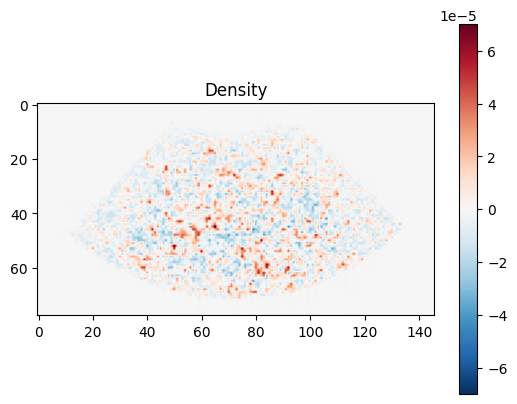

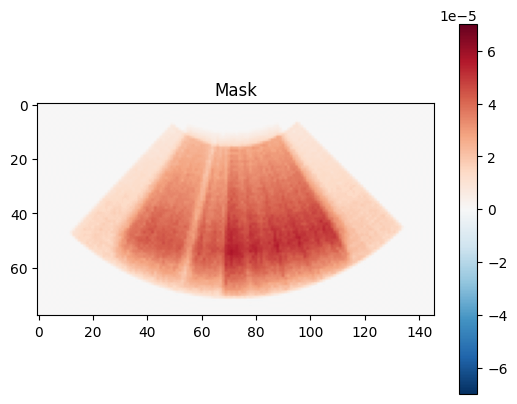

In [5]:
plotter(density_grid,vmax=0.00007,title='Density')
plotter(mask_grid,vmax=0.00007,title='Mask')

### 3. Define weighting

Next, we define a weighting scheme for the data by specifying the $\mathsf{S}^{-1}$ function. Ideally, $$\mathsf{S}^{-1} = W^T\left[W\xi W^T+N\right]^{-1}$$ where $W$ represents the mask operator, $\xi$ is the two-point function and $N$ is the noise (all treated as matrices). If the mask contains holes or local lines-of-sight, this cannot be computed analytically. We can either use an approximate weighting $\mathsf{S}^{-1}$ (which does not bias the estimator), or compute the full solution with conjugate gradient descent. 

Here, we'll assume the FKP limit. Since we already included the FKP weights when constructing the dataset, this is trivial:
$$\mathsf{S}^{-1}(\vec x,\vec y) = \delta_{\rm D}(\vec x-\vec y).$$
Strictly, the estimators require both $\mathsf{S}^{-1}$ and its transpose: here, the matrix is symmetric. There's many other features we could include in $\mathsf{S}^{-1}$, such as a downweighting of noisy modes or a full optimal weighting strategy (which is discussed below).

In [6]:
# Define a simple fiducial power spectrum
k_fid = np.arange(0.001,1.,0.001)
Pk_fid = Plin(k_fid)

# Load the PolyBin3D class
base = pb.PolyBin3D(boxsize, gridsize, 
                 Pk=[k_fid, Pk_fid], # fiducial Pk for generating MC simulations
                 boxcenter=boxcenter, # center of the simulation volume
                 pixel_window='none', # pixel window function (note that we already deconvolved it!)
                 backend='mkl', # backend for performing FFTs ('mkl' or 'fftw' for cpu, 'jax' for gpu)
                 nthreads=4, # number of CPUs for performing FFTs (only applies to 'fftw' backend)
                 sightline='local', # line-of-sight [global = z-axis, local = relative to pair]
                )

# Define filtering
def applySinv_fkp(input_data, input_type='real', output_type='real'):
    """Apply a trivial filter to the data."""
   
    # Convert the data to real/Fourier-space if necessary
    if (input_type=='fourier' and output_type=='fourier') or (input_type=='real' and output_type=='real'):
        return input_data
    elif (input_type=='fourier' and output_type=='real'):
          return base.to_real(input_data)
    elif (input_type=='real' and output_type=='fourier'):
          return base.to_fourier(input_data)

remove real_fft!

# Dimensions: [1.01e+03, 1.91e+03, 1.06e+03] Mpc/h
# Center: [7.32e+02, 1.49e+01, 2.31e+02] Mpc/h
# Line-of-sight: local
# Cartesian grid: [78, 146, 82]
# Fundamental frequency: [0.0062, 0.0033, 0.0059] h/Mpc
# Nyquist frequency: [0.242, 0.241, 0.243] h/Mpc
# Pixel window: none
# Using MKL backend


Let's test the weighting out (note that the code actually applies the weighting to the pixel-window-deconvolved data, $M^{-1}d$ rather than $d$):

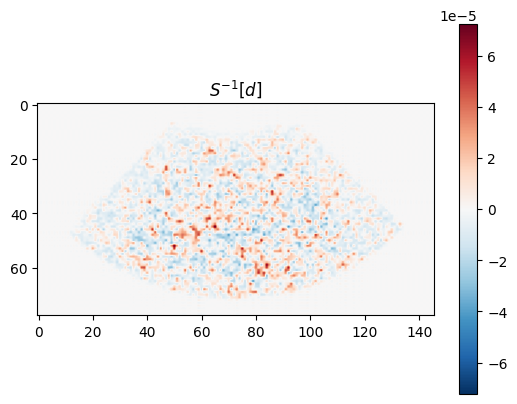

In [7]:
plotter(applySinv_fkp(density_grid),title='$S^{-1}[d]$')

### 4. Compute the usual (pseudo)-power spectra
As a first test, we'll compute the conventional window-convolved power spectra with PolyBin3D. 

To do this, we first load the power spectrum class with our choice of weighting and number density distribution. Note that we can optionally choose to include power spectra, $P_\ell(k)$, with odd $\ell$; these can be generated by wide-angle effects and mask convolution. We note that these are somewhat more difficult to compute in the unwindowed-estimator formalism as the Fisher matrix is slower to converge. However, excluding them from the calculation does *not* bias the estimation of $P_{\ell=\rm even}$, except at second-order in the small parameter $1/(kd)$, where $d$ is the distance to the sample.

After loading the class, we run the power spectrum estimator ```pspec.Pk_unwindowed()``` to compute the power spectra. Here, we'll use an idealized normalization scheme that does not correct for leakage between bins, since we want to compute *window-convolved* spectra. We'll assume a simple normalization for the windowed spectra:
$$N_2 = \frac{1}{V}\sum_{i=1}^{N_{\rm gal}} w_{i,\rm sys}w_{i,\rm FKP}^2n(z_i)$$
for comparison with *nbodykit*. This is strictly an overestimate (corrected by the window function): a more appropriate weighting would be $\frac{1}{V}\int n_{\rm gal}(\mathbf{x})n_{\rm rand}(\mathbf{x})d\mathbf{x}$.

In [8]:
# Define some k-bins and ell_max
# Using wide bins for testing!
k_edges = np.arange(0.0063,0.245,0.025)
lmax = 2

# Load the power spectrum class
pspec = pb.PSpec(base, k_edges, 
                 applySinv = applySinv_fkp, # S^-1 weighting function
                 mask = mask_grid, # pixel-window-deconvolved mask
                 lmax = lmax, # maximum multipole
                 mask_shot = shot_grid, # doubly-weighted shot-noise mask 
                 odd_l=False) # whether to include odd multipoles 

# Define FKP normalization on the grid
pk_norm = np.sum(weight_data_sys*weight_data_fkp**2*nz_data)/boxsize.prod()

# Compute the ideal normalization matrix (just encoding the bin volumes, and some discreteness effects. We don't use a fiducial power spectrum here!)
fish_ideal = pk_norm*pspec.compute_fisher_ideal(Pk_fid=None)

# Compute the *window-convolved* spectrum
Pk_fkp = pspec.Pk_unwindowed(density_grid, fish=fish_ideal, subtract_shotnoise=False)


Binning: 9 bins in [0.006, 0.231] h/Mpc
l-max: 2
Mask: spatially varying
Generating spherical harmonics
Computing ideal Fisher matrix


For comparison, we can compute the power spectrum using nbodykit:

In [9]:
# Define catalogs, giving FKP weights separately
cat = ArrayCatalog({'Position':pos_data+boxcenter, 'WEIGHT':weight_data_sys, 'WEIGHT_FKP':weight_data_fkp, 'NZ':_cat['NZ'][filt_data]})
cat_rand = ArrayCatalog({'Position':pos_rand+boxcenter, 'WEIGHT':weight_rand_sys, 'WEIGHT_FKP':weight_rand_fkp, 'NZ':_cat_rand['NZ'][filt_rand]})

# Recompute the density-field with the FKP weights applied, and shifting along the line-of-sight
cat_fkp_nb = FKPCatalog(cat.copy(), cat_rand.copy(), BoxSize=boxsize, BoxPad=0.)
density_mesh = cat_fkp_nb.to_mesh(Nmesh=gridsize, BoxCenter=boxcenter, interlaced=True, 
                               compensated=True,position='Position',
                               fkp_weight='WEIGHT_FKP', comp_weight='WEIGHT', resampler='tsc')

# Compute the nbodykit power spectrum in the same bins
r = ConvolvedFFTPower(density_mesh, kmin=k_edges[0], kmax=k_edges[-1]+1e-4, dk = k_edges[1]-k_edges[0], poles=[0,2,4])

# Reshape output
Pk_nb = {'p0':r.poles['power_0'].real,'p2':r.poles['power_2'].real,'p4':r.poles['power_4'].real}

/mnt/home/ophilcox/mpivenv2/lib/python3.9/site-packages/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/mnt/home/ophilcox/mpivenv2/lib/python3.9/site-packages/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


Let's compare the two! Below, we plot the power spectrum multipoles $P_{0,2,4}(k)$ in our $k$-bins. We find fairly good agreement in general. Slight differences arise from PolyBin3D accounting for discreteness effects in the Fourier-space grid (which gives slightly improved estimation of low-$k$ modes with $\ell>0$) and (b) small differences in the treamtent of the pixel window function. 

All the above effects will be fully accounted for by the optimal estimators, which take the gridding and discreteness effects into account in both the numerator and normalization.

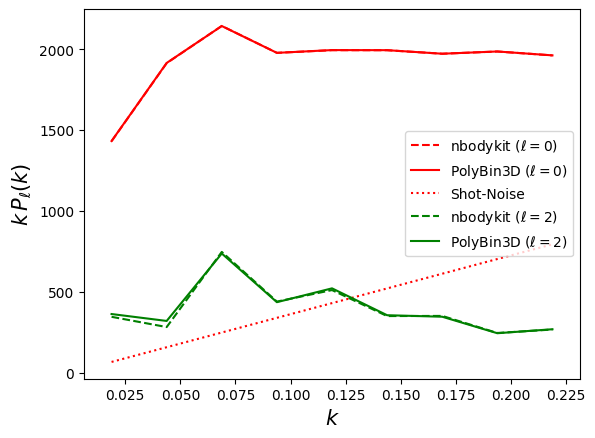

In [10]:
# Compute k 
k_cen = pspec.get_ks()

cs = {0:'r',1:'purple',2:'g',3:'orange',4:'blue'}

# Plot spectra
plt.figure()
for li,l in enumerate([0,2]):
    plt.plot(k_cen, k_cen*Pk_nb['p%d'%l],c=cs[l],ls='--',label='nbodykit ($\ell=%d$)'%l)
    plt.plot(k_cen, k_cen*Pk_fkp['p%d'%l],c=cs[l],ls='-',label='PolyBin3D ($\ell=%d$)'%l)
    if l==0:
        plt.plot(k_cen, k_cen*r.attrs['shotnoise'], label='Shot-Noise',ls=':',c='r')
    plt.legend(fontsize=10,loc='right')
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
dk = k_cen[1]-k_cen[0]
plt.xlim(k_cen[0]-dk/2,k_cen[-1]+dk/2);

### 5. Compute the "unwindowed" power spectra

Now we compute the main quantity of interest; window-deconvolved galaxy power spectrum measurements. For this, we first compute the Fisher matrix, $\mathcal{F}_{\alpha\beta}$ using Monte Carlo methods. This encodes the coupling between different modes induced by the local line-of-sight as well as mask-induced leakage and the (arbitrary) $\mathsf{S}^{-1}$ weighting. This matrix is defined by requiring that the estimator returns an unbiased estimate of the power spectrum band-powers, given the mask and $\mathsf{S}^{-1}$ function.

The Fisher matrix can be expensive to compute, should usually be paralellized. Here, we use a small number of realizations for testing (though more is usually useful in practice), computed via the ```compute_fisher_contribution``` routine. The whole computation can be wrapped via the ```compute_fisher``` method if desired. We can additionally compute the Poissonian shot-noise term in the power spectrum estimator using the ```compute_shot_contribution``` code. Note that these terms do not depend on the data, so only have to be computed once!

In [11]:
# Number of Monte Carlo iterations
N_it = 10

# Iterate over Fisher realizations
fishs = []
for s in range(N_it):
    print("Computing Fisher iteration %d of %d"%(s+1,N_it))
    fishs.append(pspec.compute_fisher_contribution(s,applySinv_transpose=applySinv_fkp,verb=(s==0)))

# Iterate over shot-noise realizations
shots = []
for s in range(N_it):
    print("Computing shot-noise iteration %d of %d"%(s+1,N_it))
    shots.append(pspec.compute_shot_contribution(100+s))

# Clean-up output, computing the mean of the quantities
fish = np.mean(fishs,axis=0)
shot_num = np.mean(shots, axis=0)

# # Alternative: compute all Fisher matrix iterations at once
# fish = pspec.compute_fisher(N_it, verb=True)

Computing Fisher iteration 1 of 10
Generating GRF
Computing A^-1.a and S^-1.P.a
Computing Legendre multipoles for A^-1.a
Computing l = 0 output
Computing l = 2 output
Computing Fisher iteration 2 of 10
Computing Fisher iteration 3 of 10
Computing Fisher iteration 4 of 10
Computing Fisher iteration 5 of 10
Computing Fisher iteration 6 of 10
Computing Fisher iteration 7 of 10
Computing Fisher iteration 8 of 10
Computing Fisher iteration 9 of 10
Computing Fisher iteration 10 of 10
Computing shot-noise iteration 1 of 10
Computing shot-noise iteration 2 of 10
Computing shot-noise iteration 3 of 10
Computing shot-noise iteration 4 of 10
Computing shot-noise iteration 5 of 10
Computing shot-noise iteration 6 of 10
Computing shot-noise iteration 7 of 10
Computing shot-noise iteration 8 of 10
Computing shot-noise iteration 9 of 10
Computing shot-noise iteration 10 of 10


Let's plot the matrix and compare it to the idealized form given above. These appear quite different; this is due to the mask- (and weighting-)induced leakage between $k$-bins and multipoles. We find significant leakage between adjacent power spectrum bins, and some minor leakage between higher-multipoles (the off-diagonal stripes in the correlation matrix). In contrast, the idealized Fisher matrix is almost diagonal (except for some small discreteness effects).

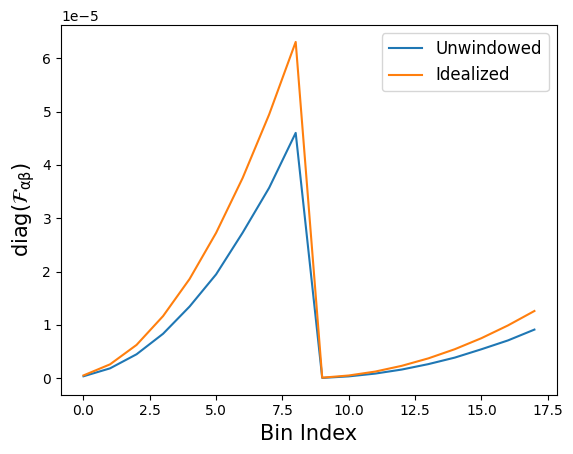

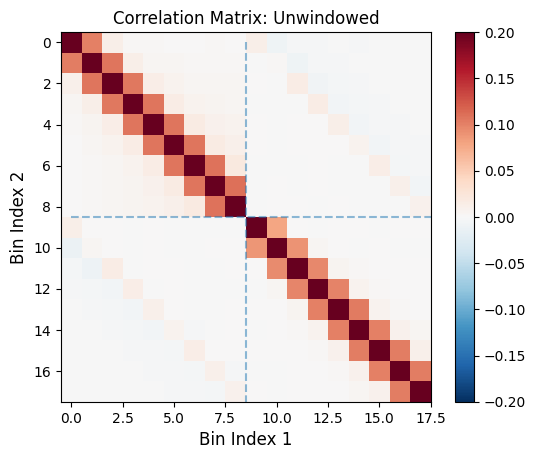

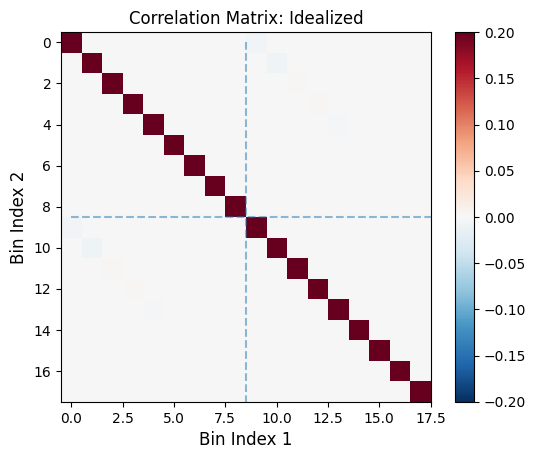

In [12]:
# Plot the diagonal
plt.plot(np.arange(len(fish)),np.diag(fish),label='Unwindowed')
plt.plot(np.diag(fish_ideal),label='Idealized')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$\rm{diag}(\mathcal{F}_{\alpha\beta})$',fontsize=15);
plt.legend(fontsize=12);

# Plot the correlation structure
plot_corr(fish,v=0.2,subtract_identity=False,title='Correlation Matrix: Unwindowed')
plot_corr(fish_ideal,v=0.2,subtract_identity=False,title='Correlation Matrix: Idealized')

We now compute the power spectra, using the same routines as before, but feeding in our new Fisher matrix. We'll also consider varying the Fisher matrix to establish the impact of Monte Carlo noise in the Fisher matrix computation.

In [13]:
# Compute unwindowed power spectra
Pk_unwindowed = pspec.Pk_unwindowed(density_grid, fish=fish, shot_num=shot_num, subtract_shotnoise=False)

## Print number of FFTs used for diagnostics
print("Computations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))

# Estimate Monte Carlo error by using two estimates of the Fisher matrix
fish1 = np.mean(fishs[:N_it//2],axis=0)
fish2 = np.mean(fishs[N_it//2:],axis=0)
Pk1 = pspec.Pk_unwindowed(density_grid, fish=fish1, shot_num=shot_num, subtract_shotnoise=False)
Pk2 = pspec.Pk_unwindowed(density_grid, fish=fish2, shot_num=shot_num, subtract_shotnoise=False)
Pk_err = {key: np.abs(Pk1[key]-Pk2[key]) for key in Pk_unwindowed}

Computations complete using 472 forward and 702 reverse FFTs


Let's plot the power spectra below. We find a couple of important conclusions:
- Unwindowed power spectra are $\sim  10\%$ larger than the windowed equivalents. This reflects a known issue with the normalization of FKP spectra - the $N_2$ factor used in nbodykit is a slight overestimate (which is captured by the window function). Here, we define the normalization completely in terms of the random catalog. If we rescale to a more physical normalization (the dotted lines below), we find much better agreement.
- There is some residual uncertainty from the Monte Carlo computation of the Fisher matrix, particularly in the higher multipoles. This can be reduced by using more Monte Carlo realizations.
- The output spectra from PolyBin3D are (approximately) unwindowed *i.e.* they can be compared directly to theory, without need for window convolution. This assumes that the $k$-range given to PolyBin3D encompasses all relevant modes. For the highest $k$-modes in our estimator, we will miss contributions from modes at slightly higher $k$, thus these should generally be discarded (see e.g. the last monopole bin below). This can easily be ameliorated by measuring a larger range of $k$ than used in practice.

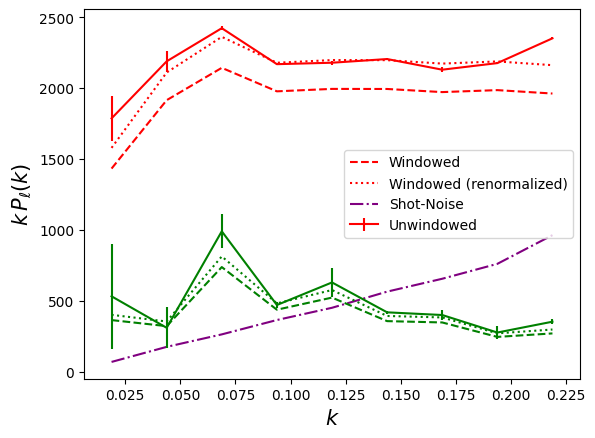

In [14]:
# Compute k 
k_cen = pspec.get_ks()

cs = {0:'r',1:'purple',2:'g',3:'orange',4:'blue'}

# Define shot-noise
Pk_shot = {'p%d'%l:pspec.shot[l//2*pspec.Nk:(l//2+1)*pspec.Nk] for l in [0,2,4]}

# Compute alternative normalization for windowed measurements
pk_norm_new = np.sum(mesh_data*mesh_rand)*alpha/gridsize.prod()

# Plot spectra
plt.figure()
for li,l in enumerate([0,2]):
    plt.errorbar(k_cen, k_cen*Pk_unwindowed['p%d'%l],yerr=k_cen*Pk_err['p%d'%l],
                 c=cs[l],ls='-',label='Unwindowed')
    plt.plot(k_cen, k_cen*Pk_fkp['p%d'%l],c=cs[l],ls='--',label='Windowed')
    plt.plot(k_cen, k_cen*Pk_fkp['p%d'%l]*(pk_norm/pk_norm_new),c=cs[l],ls=':',label='Windowed (renormalized)')
    if li==0: plt.plot(k_cen, k_cen*Pk_shot['p%d'%l],c='purple',ls='-.',label='Shot-Noise')
    if li==0: plt.legend(fontsize=10)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
dk = k_cen[1]-k_cen[0]
plt.xlim(k_cen[0]-dk/2,k_cen[-1]+dk/2);

### 5a. Bonus #1: compute rectangular binning matrices

A potential limitation of the unwindowed estimators is that, in order to compare theory and data, one should strictly integrate the theoretical spectra, $P_\ell^{\rm th}(k)$ across each bin. If the bins are sufficiently narrow, this can be avoided, *i.e.* we can assume that the power spectra output by PolyBin3D match the power spectrum evaluated at the center of each bin. For wide bins, one should perform the bin integral, however this is non-trivial since the weighting depends on the mask. 

Below, we discuss how to compute the bin-integration using the ```compute_theory_contribution``` routine. Essentially, one first computes the expectation of the bin numerator
$$\langle{\hat{q}_\alpha\rangle} = \sum_{\gamma}\mathcal{G}_{\alpha\gamma}p_\gamma,$$
where $p_\gamma$ are the band-powers in some *finely-binned* scheme. Then the theoretical expectation of the PolyBin3D outputs, $\hat{p}_\alpha$ are related to the finely binned truth by
$$\langle{\hat{p}_\alpha\rangle} = \sum_\gamma \left[\mathcal{F}^{-1}\mathcal{G}\right]_{\alpha\gamma}p_\gamma.$$
(This is analogous to the bin-convolution matrices in the NaMaster formalism.) We here compute both the coupling matrix $\mathcal{G}_{\alpha\gamma}$ and the usual Fisher matrix $\mathcal{F}$ using Gaussian random field simulations, as for the Fisher matrix $\mathcal{F}$. Usefully, the total number of FFTs scales as the number of *broad* $k$-bins, not the number of *narrow* $k$-bins. 

For this test, we'll use a finer $k$-binning, with roughly ten times the number of bins, and assume the FKP weighting scheme, as before. We'll also include the leakage from the $\ell=4$ modes into $\ell=0,2$. Notably, this can also be used to correct for leading-order wide-angle contributions ($P_{1,3}^{(1)}$), which are generated entirely from $P_{0,2,4}$. 

In [15]:
# First define k-binning
k_edges_th = np.arange(0.0063,0.241,0.002)

# Iterate over realizations
theory_matrices = []
fishs = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    fish, theory_matrix = pspec.compute_theory_contribution(s,
                                                            applySinv_transpose = applySinv_fkp, 
                                                            k_bins_theory = k_edges_th, # theoretical k binning 
                                                            lmax_theory = 4, # theoretical lmax
                                                            include_wideangle = False, # whether to correct for wide-angle effects
                                                            verb=(s==0))
    theory_matrices.append(theory_matrix)
    fishs.append(fish)
    
theory_matrix = np.mean(theory_matrices, axis=0)
fish = np.mean(fishs, axis=0)

Computing iteration 1 of 10
Generating spherical harmonics up to l = 4
Generating GRF
Computing A^-1.a and S^-1.P.a
Computing Legendre multipoles for A^-1.a
Computing l = 0 output
Computing l = 2 output
Computing iteration 2 of 10
Computing iteration 3 of 10
Computing iteration 4 of 10
Computing iteration 5 of 10
Computing iteration 6 of 10
Computing iteration 7 of 10
Computing iteration 8 of 10
Computing iteration 9 of 10
Computing iteration 10 of 10


We can now compute the full binning matrix $\mathcal{F}^{-1}\mathcal{G}$. We'll compute this assuming both the unwindowed Fisher matrix $\mathcal{F}$ and the ideal limit.

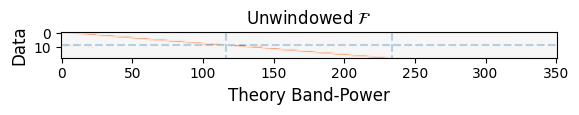

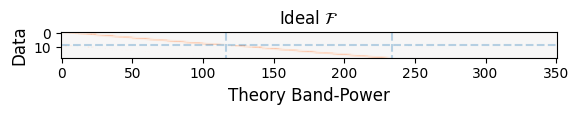

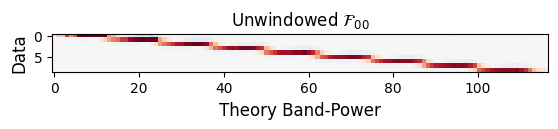

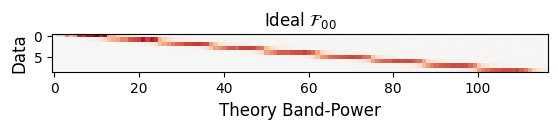

In [16]:
k_cen_th = 0.5*(k_edges_th[1:]+k_edges_th[:-1])

# Apply the F^-1 matrices
correction_matrix = np.matmul(np.linalg.inv(fish),theory_matrix)
correction_matrix_ideal = np.matmul(np.linalg.inv(fish_ideal),theory_matrix)

def plot_matrix(matrix, vmax=1, lmax=lmax, lmax_th=4, title=''):
    plt.figure()
    plt.imshow(matrix,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.title(title)
    for i in range(1,lmax//2+1):
        plt.hlines(i*pspec.Nk-0.5,0,len(k_cen_th)*3,linestyles='--',alpha=0.3)
    for i in range(1,lmax_th//2+1):
        plt.vlines(len(k_cen_th)*i-0.5,0,pspec.Nk*3,linestyles='--',alpha=0.3)
    plt.xlim(-0.5,len(k_cen_th)*(lmax_th//2+1)-0.5)
    plt.ylim(pspec.Nk*(lmax//2+1)-0.5,-0.5);
    plt.xlabel(r'Theory Band-Power',fontsize=12);
    plt.ylabel(r'Data',fontsize=12);

plot_matrix(correction_matrix, 0.25, title='Unwindowed $\mathcal{F}$')
plot_matrix(correction_matrix_ideal, 0.25, title='Ideal $\mathcal{F}$')

# Zoom-In on ell=0
plot_matrix(correction_matrix, 0.1, lmax=0, lmax_th=0, title='Unwindowed $\mathcal{F}_{00}$')
plot_matrix(correction_matrix_ideal, 0.1, lmax=0, lmax_th=0, title='Ideal $\mathcal{F}_{00}$')

Whilst the matrices are still a little noisy it's clear that there's a lot of leakage between even far-separated bins if we assume the ideal normalization (which does not *de-window* the spectra), but significantly less with the full unwindowed Fisher matrix. There, the majority all of the contributions come from modes within the band-power (the diagonal stripe), as expected, with negative contributions at the edges of the bins. 

This can be visualized by plotting the contributions to each bin as a function of $k_{\rm theory}$. We'll do this for a few bins below:

Text(0, 0.5, 'Correction Matrix ($\\ell=0$)')

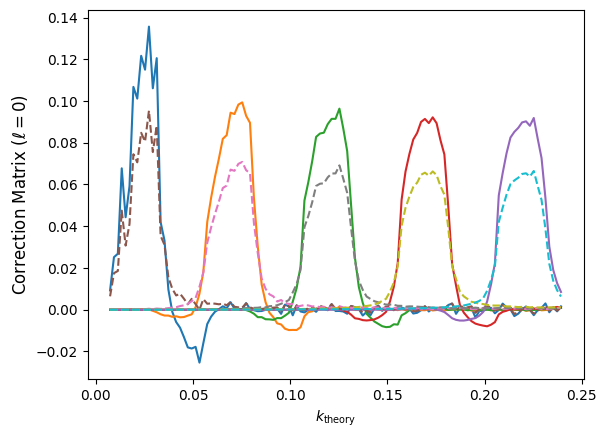

In [17]:
plt.plot(k_cen_th, correction_matrix[:pspec.Nk:2,:len(k_cen_th)].T)
plt.plot(k_cen_th, correction_matrix_ideal[:pspec.Nk:2,:len(k_cen_th)].T,ls='--')
plt.xlabel(r'$k_{\rm theory}$')
plt.ylabel(r'Correction Matrix ($\ell=0$)',fontsize=12)

Finally, we can compare the theory predictions using the above correction matrix. The results are very similar (except for the final bin, which we'd usually discard)! This indicates that the effect of varying weights within each bin are small and can usually be ignored, unless the bin width is very large.

Text(0, 0.5, '$k\\,P_\\ell(k)$')

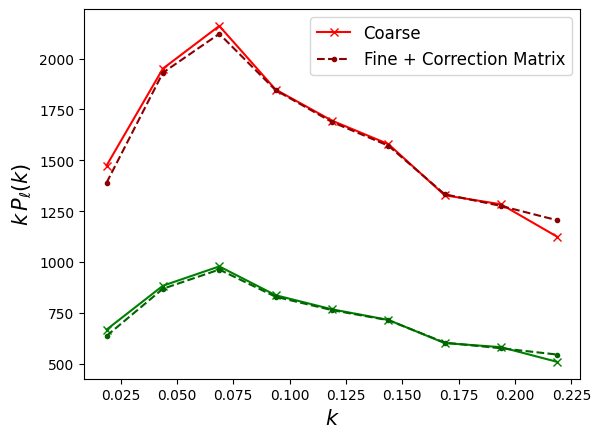

In [18]:
# Define simple theory power spectrum (assuming the Kaiser formula, without shot-noise)
k_arr = np.arange(0.0001,1.,0.001)
b1 = 1.8
redshift = np.average(_cat['Z'],weights=_weight_data_sys)
fz = cosmo.scale_independent_growth_rate(redshift)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr

# Input finely binned theory
p_th = np.concatenate([interp1d(k_arr,P0_arr)(k_cen_th),
                       interp1d(k_arr,P2_arr)(k_cen_th),
                       interp1d(k_arr,P4_arr)(k_cen_th)])
# Theory evaluated at bin-centers
p_raw = np.concatenate([interp1d(k_arr,P0_arr)(k_cen),
                        interp1d(k_arr,P2_arr)(k_cen),
                        interp1d(k_arr,P4_arr)(k_cen)])
# Convolved finely-binned theory
p_conv = np.matmul(correction_matrix,p_th)

cs = {0:'r',2:'g',4:'blue'}
cs2 = {0:'darkred',2:'darkgreen',4:'darkblue'}
for l in [0,2]:
    plt.plot(k_cen,k_cen*p_raw[l//2*pspec.Nk:(l//2+1)*pspec.Nk],ls='-',marker='x',c=cs[l], label='Coarse')
    plt.plot(k_cen,k_cen*p_conv[l//2*pspec.Nk:(l//2+1)*pspec.Nk],ls='--',marker='.',c=cs2[l], label='Fine + Correction Matrix')
    if l==0: plt.legend(fontsize=12)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15)

### 5b. Bonus #2: compute covariance matrices

If our power spectrum estimator is optimal, the inverse Fisher matrix, $\mathcal{F}^{-1}$, should be equal to the (masked) Gaussian covariance matrix. In practice, this is rarely true, since we typically use an approximate form for the weighting instead of the optimal solution. Furthermore, we may wish to downweight some noisy modes. 

We can compute a general covariance matrix in PolyBin3D, similarly to how we computed the Fisher normalization. This is the usual power spectrum covariance for masked data assuming Gaussianity (i.e. ignoring the trispectrum terms). We will need to specify a fiducial power spectrum for this, as in the previous section. For simplicity, we'll use a simple linear theory model here. Note that this **must** include shot-noise!

In [19]:
# Iterate over realizations
covs = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    cov = pspec.compute_covariance_contribution(1000+s,
                                                applySinv_transpose=applySinv_fkp,
                                                Pk_cov = [k_arr, P0_arr+r.attrs['shotnoise'], P2_arr], # power spectra including shot-noise
                                                verb=(s==1000))
    covs.append(cov)

# Assemble (unwindowed) covariance, including the necessary factors of F^{-1}
inv_fish = np.linalg.inv(fish)
cov = inv_fish@np.mean(covs, axis=0)@inv_fish.T

Computing iteration 1 of 10
Computing iteration 2 of 10
Computing iteration 3 of 10
Computing iteration 4 of 10
Computing iteration 5 of 10
Computing iteration 6 of 10
Computing iteration 7 of 10
Computing iteration 8 of 10
Computing iteration 9 of 10
Computing iteration 10 of 10


Below, we compare the covariance matrix to the optimal expectation, $\mathcal{F}^{-1}$. Notably, the full covariance (which is the complete Gaussian covariance of the masked data) looks quite different to the inverse Fisher matrix. This is due to the approximate form of the $\mathsf{S}^{-1}$ weighting -- in particular, it the FKP weights are only calibrated to a single bin of $P(k)$! Whilst $\mathcal{F}^{-1}$ gives a useful indication of the correlation structure for the monopole, we should use the full Gaussian covariance in practice.

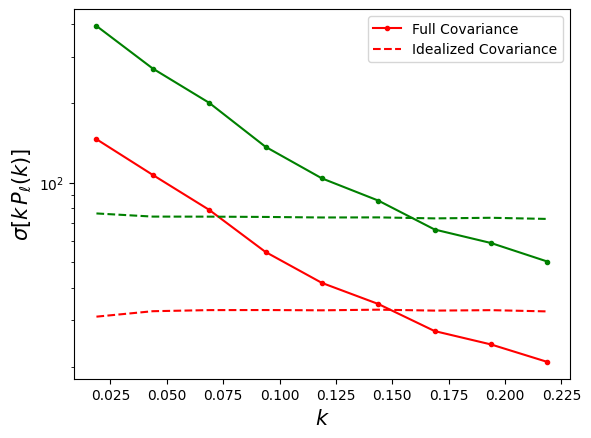

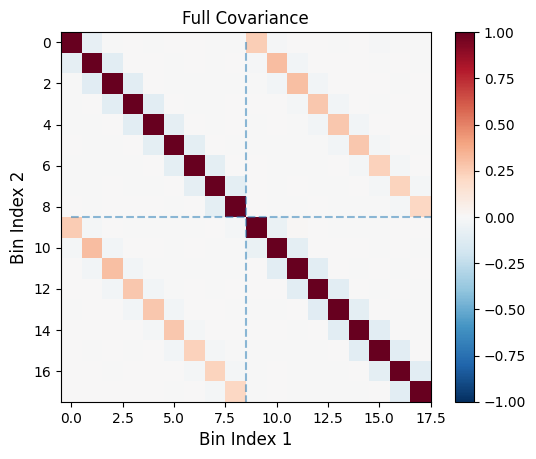

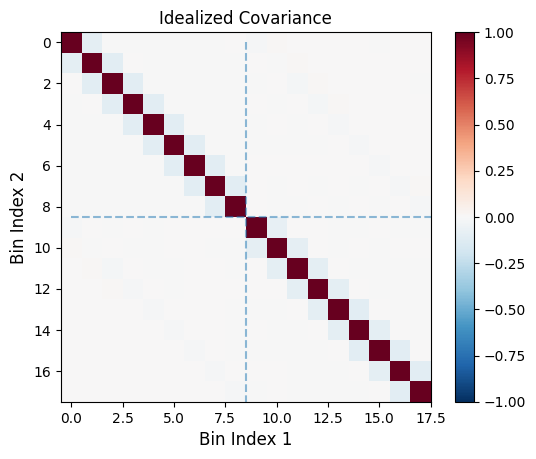

In [20]:
ideal_cov = np.linalg.inv(fish)

# Plot the variances
for li,l in enumerate([0,2]):
    plt.errorbar(k_cen, k_cen*np.sqrt(np.diag(cov)[len(k_cen)*li:len(k_cen)*(li+1)]), c=cs[l],marker='.',label='Full Covariance')
    plt.errorbar(k_cen, k_cen*np.sqrt(np.diag(ideal_cov)[len(k_cen)*li:len(k_cen)*(li+1)]),c=cs[l],ls='--',label='Idealized Covariance')
    if li==0: plt.legend();
plt.yscale('log')
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$\sigma[k\,P_\ell(k)]$',fontsize=15)

plot_corr(cov,subtract_identity=False,title='Full Covariance')
plot_corr(ideal_cov,subtract_identity=False,title='Idealized Covariance')

Finally, we can plot both the unwindowed and windowed data, with their Gaussian covariances. This is a powerful result: we can now estimate the data, the window functions, and the covariance without simulations!

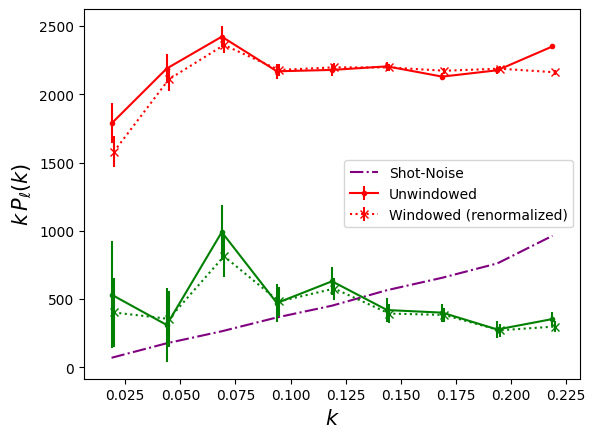

In [21]:
# Create windowed and unwindowed covariances 
inv_fish_ideal = np.linalg.inv(fish_ideal)
cov_fkp = inv_fish_ideal@np.mean(covs, axis=0)@inv_fish_ideal.T
cov_unwindowed = inv_fish@np.mean(covs, axis=0)@inv_fish.T

# Plot spectra
plt.figure()
for li,l in enumerate([0,2]):
    plt.errorbar(k_cen, k_cen*Pk_unwindowed['p%d'%l],yerr=k_cen*np.sqrt(np.diag(cov_unwindowed)[len(k_cen)*li:len(k_cen)*(li+1)]),
                 c=cs[l],ls='-',marker='.',label='Unwindowed')
    plt.errorbar(k_cen+0.001, k_cen*Pk_fkp['p%d'%l]*(pk_norm/pk_norm_new),yerr=k_cen*np.sqrt(np.diag(cov_fkp)[len(k_cen)*li:len(k_cen)*(li+1)])*(pk_norm/pk_norm_new),
             c=cs[l],ls=':',marker='x',label='Windowed (renormalized)')
    if li==0: plt.plot(k_cen, k_cen*Pk_shot['p%d'%l],c='purple',ls='-.',label='Shot-Noise')
    if li==0: plt.legend(fontsize=10)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
dk = k_cen[1]-k_cen[0]
plt.xlim(k_cen[0]-dk/2,k_cen[-1]+dk/2);

### 5c. Bonus #3: compute optimally-weighted spectra

Although the above spectra are window-deconvolved they are not quite optimal, due to the simplifying FKP-like $\mathsf{S}^{-1}$ assumed. In the below, we'll compute the spectra using the optimal $\mathsf{S}^{-1}$. Applied to a vector $u$ (which doesn't vanish with the mask), the inverse can be obtained by solving
$$[W\xi + \mathsf{N}W^{-1}]\left(\mathsf{S}^{-1}u\right) = u$$
(where $W$ is the mask and $\mathsf{N}$ specifies the shot-noise) for $\mathsf{S}^{-1}u$ via conjugate gradient descent methods. Below, we implement this, computing the correlation function term in Fourier space, assuming a local line-of-sight. We'll replace $\mathsf{N}/W$ by an appropriate average to avoid errors when the mask is close to zero. Furthermore, we'll use a smooth mask to weight the data here instead of the (discrete) mask computed from the random catalog -- note that this is used *only* to weight the data and not to derive the Fisher matrix.

We will also need the transpose, $\mathsf{S}^{-\dagger}$. This can be computed from a similar equation:
$$[\xi W + \mathsf{N}W^{-1}]\left(\mathsf{S}^{-\dagger}u\right) = u$$.

In [22]:
### DEFINE THE SMOOTH MASK

# Histogram the z values, giving dN = n(z)*dz
nz,z = np.histogram(_cat['Z'],bins=np.arange(ZMIN-0.005,ZMAX+0.0051,0.005),weights=_weight_data_sys*_weight_data_fkp,range=[ZMIN-0.005,ZMAX+0.005])
z_av = 0.5*(z[:-1]+z[1:])
rz = cosmo.comoving_distance(z)

# Convert to volume density i.e. dN = n_z(z)dV
f_sky = eff_area/(4.*np.pi*(180./np.pi)**2.)
volz = 4.*np.pi/3.*(rz[1:]**3.-rz[:-1]**3.)*f_sky
nz_interp = UnivariateSpline(z_av,nz/volz,s=0.0000000000001)

# Create a grid of n(z) for each voxel
ra_grid, dec_grid, z_grid = transform.CartesianToSky(np.asarray([r.ravel() for r in base.r_grids]).T,cosmo)
ra_grid = ra_grid.compute().reshape(base.r_grids[0].shape)
dec_grid = dec_grid.compute().reshape(base.r_grids[0].shape)
z_grid = z_grid.compute().reshape(base.r_grids[0].shape)
nz_grid = nz_interp(z_grid)

# Broadly pixelize the RA / Dec coordinates
Nside = 64
hp_pixels = hp.ang2pix(Nside, _cat['RA'][filt_data], _cat['DEC'][filt_data], lonlat=True)
hp_map = np.zeros(hp.nside2npix(64))
hp_map[hp_pixels] = 1

# Define the edges of the mask
zero_grid = hp_map[hp.ang2pix(Nside, ra_grid, dec_grid, lonlat=True)]*(z_grid>=ZMIN)*(z_grid<ZMAX)

# Combine to form the mask
smooth_mask = nz_grid*zero_grid

# Load some useful cython functions used in PolyBin3D
from PolyBin3D.cython import utils

# Define simple theory power spectrum (assuming the Kaiser formula, without shot-noise)
k_arr = np.arange(0.0001,1.1*np.max(base.modk_grid),0.0001)
b1 = 1.8
redshift = np.average(_cat['Z'],weights=_weight_data_sys)
fz = cosmo.scale_independent_growth_rate(redshift)
Plin_arr = Plin(k_arr)
k_arr = np.concatenate([[0],k_arr])
Plin_arr = np.concatenate([[Plin_arr[0]],Plin_arr])
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr

# Interpolate the power spectra to a grid
Pkl_grid = {0:interp1d(k_arr, P0_arr, bounds_error=True)(base.modk_grid),
            2:interp1d(k_arr, P2_arr, bounds_error=True)(base.modk_grid),
            4:interp1d(k_arr, P4_arr, bounds_error=True)(base.modk_grid)
           }

# Define maximum ell to use in covariance
lmax_filtering = 2

# Compute the shot-noise amplitude
beta = np.mean(shot_grid[smooth_mask!=0])/np.mean(mask_grid[smooth_mask!=0])

In [23]:
# Function to apply the forward matrix
def apply_matrix(_input_map):
    """Apply the matrix [W xi + N / W](x, y)Phi(y) to a map."""
    
    # Transform to Fourier-space
    input_map = _input_map.copy()
    input_map_fourier = base.to_fourier(input_map)
    
    # Apply the power spectrum in Fourier-space
    xi_dot_fourier = utils.prod_map(input_map_fourier, Pkl_grid[0], base.nthreads)
    xi_dot_real = np.zeros(base.gridsize, dtype=np.float64)
    if lmax_filtering>0:
        for l in range(2,lmax_filtering+1,2):
            # First contribution
            leg_map = np.zeros(base.modk_grid.shape, dtype=np.complex128)
            for lm_ind in range(len(pspec.Ylm_real[l])):
                map_lm = utils.prod_map_real(input_map, pspec.Ylm_real[l][lm_ind],base.nthreads)
                utils.prod_map_sum(base.to_fourier(map_lm), pspec.Ylm_fourier[l][lm_ind], leg_map, base.nthreads)
            xi_dot_fourier += 0.5*utils.prod_map(leg_map, Pkl_grid[l], base.nthreads)
            # Second contribution
            Pk_map = utils.prod_map(input_map_fourier, Pkl_grid[l], base.nthreads)
            leg_map = np.zeros(base.modk_grid.shape, dtype=np.float64)
            for lm_ind in range(len(pspec.Ylm_real[l])):
                map_lm = utils.prod_map(Pk_map, pspec.Ylm_fourier[l][lm_ind], base.nthreads)
                utils.prod_map_real_sum(base.to_real(map_lm), pspec.Ylm_real[l][lm_ind], leg_map, base.nthreads)
            xi_dot_real += 0.5*leg_map
    
    # Compute output in real-space
    xi_dot_real += base.to_real(xi_dot_fourier)
    
    # Apply the mask and Poisson noise
    output_map = smooth_mask*xi_dot_real + beta*input_map
    
    # Return output
    return output_map

def apply_transpose_matrix(_input_map):
    """Apply the matrix Phi(x)[xi W + N / W](x, y) to a map."""
    
    # Apply the mask and transform to Fourier-space
    input_map = _input_map.copy()
    masked_map = smooth_mask*input_map
    masked_map_fourier = base.to_fourier(masked_map)
    
    # Apply the power spectrum in Fourier-space
    xi_dot_fourier = utils.prod_map(masked_map_fourier, Pkl_grid[0], base.nthreads)
    xi_dot_real = np.zeros(base.gridsize, dtype=np.float64)
    if lmax_filtering>0:
        for l in range(2,lmax_filtering+1,2):
            # First contribution
            leg_map = np.zeros(base.modk_grid.shape, dtype=np.complex128)
            for lm_ind in range(len(pspec.Ylm_real[l])):
                map_lm = utils.prod_map_real(masked_map, pspec.Ylm_real[l][lm_ind],base.nthreads)
                utils.prod_map_sum(base.to_fourier(map_lm), pspec.Ylm_fourier[l][lm_ind], leg_map, base.nthreads)
            xi_dot_fourier += 0.5*utils.prod_map(leg_map, Pkl_grid[l], base.nthreads)
            # Second contribution
            Pk_map = utils.prod_map(masked_map_fourier, Pkl_grid[l], base.nthreads)
            leg_map = np.zeros(base.modk_grid.shape, dtype=np.float64)
            for lm_ind in range(len(pspec.Ylm_real[l])):
                map_lm = utils.prod_map(Pk_map, pspec.Ylm_fourier[l][lm_ind], base.nthreads)
                utils.prod_map_real_sum(base.to_real(map_lm), pspec.Ylm_real[l][lm_ind], leg_map, base.nthreads)
            xi_dot_real += 0.5*leg_map
    
    # Compute output in real-space
    xi_dot_real += base.to_real(xi_dot_fourier)
    
    # Add the Poisson noise and null modes outside the mask
    output_map = (smooth_mask!=0)*xi_dot_real + beta*input_map
    
    # Return output
    return output_map

# CGD function
def cgd_inverse(input_map, _apply_matrix=apply_matrix, applySinv_approx=applySinv_fkp, max_it=25, rel_tol=1e-3, verb=False):
    """Compute the conjugate gradient descent inverse solution for S^-1."""
    
    # Start timer
    start = time.time()
    
    # define initial guess for inverse and first term in sequence
    if verb: print("Computing initial guess")
    x = applySinv_approx(input_map)
    r = input_map - _apply_matrix(x)
    p = applySinv_approx(r)
    C_p = _apply_matrix(p)

    pre_r = applySinv_approx(r)
    old_sum = np.sum(r*pre_r)
    init_sum = old_sum.copy()
    alpha = old_sum/np.sum(p*C_p)
    save_sum = old_sum.copy()

    assert max_it < len(input_map.ravel())

    for i in range(max_it):
        if i>0 and verb: print("Starting iteration %d of %d: ratio = %.2e"%(i,max_it,np.sqrt(new_sum/init_sum)))
        
        if i%10==0 and i>0:
            # Check for stalling and stop if stalled
            if np.abs((save_sum-old_sum)/old_sum)<0.05:
                if verb: print("Inversion stalled after step %d; exiting (ratio %.2e/%.2e)"%(i+1,new_sum,init_sum))
                break
        
        # update x
        x = x+alpha*p
        # update r
        r = r-alpha*C_p
        # update S_approx^-1.r
        pre_r = applySinv_approx(r)
        # update sum(r * S_approx^-1.r)
        new_sum = np.sum(r*pre_r)
        # update p
        p = pre_r + (new_sum/old_sum)*p
        # Check for convergence
        if new_sum/init_sum<0:
            print("Bad sum on iteration %d (ratio %.2e/%.2e"%(i,new_sum,init_sum))
            break
        if np.sqrt(new_sum/init_sum)<rel_tol:
            if verb: print("Inversion stopped early after %d iterations (ratio %.2e/%.2e)"%(i+1,new_sum,init_sum))
            break
        
        # update sum
        old_sum = new_sum
        # update C.p
        C_p = _apply_matrix(p)
        # compute alpha
        alpha = old_sum/np.sum(p*C_p)
    if i==max_it-1:
        if verb: print("CGD did not stop early: is this converged? (ratio %.2e/%.2e)"%(new_sum,init_sum))
    if verb:
        print("\nInversion took %.1f seconds"%(time.time()-start))
    return x

Let's test this by applying the CGD to a pixel-window-deconvolved map. We find that the CGD has found the correct solution to the target accuracy (here $\sim 1\%$), though this usually requires quite a few number of Fourier transforms. The efficiency of the CGD inversion depends primarily on the choice of preconditioner, i.e. the approximate $\mathsf{S}^{-1}$ assumed to begin with. Here, we'll assume the FKP form for simplicity, though other options may give faster convergence.

Computing initial guess
Starting iteration 1 of 25: ratio = 5.91e-01
Starting iteration 2 of 25: ratio = 5.15e-01
Starting iteration 3 of 25: ratio = 4.25e-01
Starting iteration 4 of 25: ratio = 2.52e-01
Starting iteration 5 of 25: ratio = 1.42e-01
Starting iteration 6 of 25: ratio = 9.45e-02
Starting iteration 7 of 25: ratio = 8.04e-02
Starting iteration 8 of 25: ratio = 6.99e-02
Starting iteration 9 of 25: ratio = 5.04e-02
Starting iteration 10 of 25: ratio = 3.26e-02
Starting iteration 11 of 25: ratio = 2.16e-02
Starting iteration 12 of 25: ratio = 1.64e-02
Starting iteration 13 of 25: ratio = 1.24e-02
Inversion stopped early after 14 iterations (ratio 2.04e-07/2.99e-03)

Inversion took 8.8 seconds


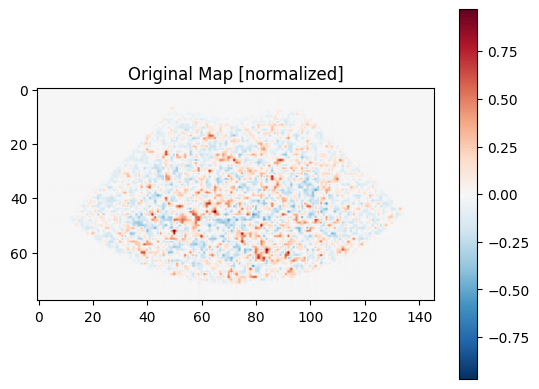

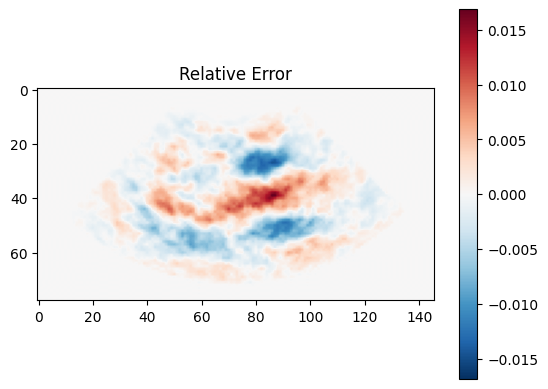

In [24]:
# Define input map, removing the pixel window if necessary
if base.pixel_window!='none':
    input_map = base.to_real(base.to_fourier(density_grid)/base.pixel_window_grid)
else:
    input_map = density_grid
    
# Apply CGD inverse
Sinv_map = cgd_inverse(input_map, apply_matrix, applySinv_approx=applySinv_fkp, max_it=25, verb=True, rel_tol=1e-2)

# Plot, comparing [W xi + N/W].Phi.S^-1.x to the original map, x
plotter(input_map/smooth_mask[smooth_mask!=0].mean(),title='Original Map [normalized]')
plotter((input_map-apply_matrix(Sinv_map))/smooth_mask[smooth_mask!=0].mean(),title='Relative Error')

Now we can wrap the inverse (and ints transpose) in an $\mathsf{S}^{-1}$ function and proceed to compute the power spectrum and Fisher matrix! This will take quite a bit longer than before since each application of $\mathsf{S}^{-1}$ is quite expensive (and we have to compute it $N_{\rm bins}+1$ times), so we'll just use a few Monte Carlo realizations. Note that we can use a relatively poor error-tolerance on the CGD; as long as we use the same *approximate* form for $\mathsf{S}^{-1}$ everywhere, the estimator will be unbiased.

In [25]:
# Define filtering
def applySinv_optimal(input_data, input_type='real', output_type='real'):
    """Apply an optimal filter to the data, using conjugate gradient descent."""
   
    # Read in the data, and convert it to real-space if necessary
    if input_type=='fourier':
        input_real = base.to_real(input_data)
    else:
        input_real = input_data.copy()
    
    # Apply optimal weight in real-space
    output_real = cgd_inverse(input_real, apply_matrix, max_it=25, rel_tol=1e-2, verb=False)
    
    # Return output in real- or Fourier-space
    if output_type=='real':
        return output_real
    else:
        return base.to_fourier(output_real)
    
# Define filtering
def applySinv_transpose_optimal(input_data, input_type='real', output_type='real'):
    """Apply an optimal filter to the data, using conjugate gradient descent."""
   
    # Read in the data, and convert it to real-space if necessary
    if input_type=='fourier':
        input_real = base.to_real(input_data)
    else:
        input_real = input_data.copy()
    
    # Apply optimal weight in real-space
    output_real = cgd_inverse(input_real, apply_transpose_matrix, max_it=25, rel_tol=1e-3, verb=False)
    
    # Return output in real- or Fourier-space
    if output_type=='real':
        return output_real
    else:
        return base.to_fourier(output_real)

# Load the power spectrum class
pspec_opt = pb.PSpec(base, k_edges, 
                 applySinv = applySinv_optimal, # S^-1 weighting function
                 mask = mask_grid, # pixel-window-deconvolved mask
                 lmax = lmax, # maximum multipole
                 odd_l = False, # whether to include odd multipoles  
                 mask_shot = shot_grid, # shot-noise mask
                )


Binning: 9 bins in [0.006, 0.231] h/Mpc
l-max: 2
Mask: spatially varying
Generating spherical harmonics


In [26]:
# Zero counters
base.n_FFTs_forward = 0
base.n_FFTs_reverse = 0

# Iterate over Fisher matrix realizations
fishs_opt = []
for s in range(N_it):
    print("Computing Fisher matrix iteration %d of %d"%(s+1,N_it))
    fishs_opt.append(pspec_opt.compute_fisher_contribution(s,verb=(s==0), applySinv_transpose=applySinv_transpose_optimal))
    
# Clean-up output, computing the mean of the quantities
fish_opt = np.mean(fishs_opt,axis=0)

# Iterate over shot-noise realizations
shots = []
for s in range(N_it):
    print("Computing shot-noise iteration %d of %d"%(s+1,N_it))
    shots.append(pspec_opt.compute_shot_contribution(100+s))
    
# Clean-up output, computing the mean of the quantities
shot_num_opt = np.mean(shots,axis=0)

# Compute unwindowed power spectra
Pk_unwindowed_opt = pspec_opt.Pk_unwindowed(density_grid, fish=fish_opt, shot_num=shot_num_opt, subtract_shotnoise=False)

## Print number of FFTs used for diagnostics
print("Computations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))

# Estimate Monte Carlo error by using two estimates of the Fisher matrix
fish_opt1 = np.mean(fishs_opt[:N_it//2],axis=0)
fish_opt2 = np.mean(fishs_opt[N_it//2:],axis=0)
Pk_opt1 = pspec_opt.Pk_unwindowed(density_grid, fish=fish_opt1, shot_num=shot_num_opt, subtract_shotnoise=False)
Pk_opt2 = pspec_opt.Pk_unwindowed(density_grid, fish=fish_opt2, shot_num=shot_num_opt, subtract_shotnoise=False)
Pk_opt_err = {key: np.abs(Pk_opt1[key]-Pk_opt2[key]) for key in Pk_unwindowed_opt}

Computing Fisher matrix iteration 1 of 10
Generating GRF
Computing A^-1.a and S^-1.P.a
Computing Legendre multipoles for A^-1.a
Computing l = 0 output
Computing l = 2 output
Computing Fisher matrix iteration 2 of 10
Computing Fisher matrix iteration 3 of 10
Computing Fisher matrix iteration 4 of 10
Computing Fisher matrix iteration 5 of 10
Computing Fisher matrix iteration 6 of 10
Computing Fisher matrix iteration 7 of 10
Computing Fisher matrix iteration 8 of 10
Computing Fisher matrix iteration 9 of 10
Computing Fisher matrix iteration 10 of 10
Computing shot-noise iteration 1 of 10
Computing shot-noise iteration 2 of 10
Computing shot-noise iteration 3 of 10
Computing shot-noise iteration 4 of 10
Computing shot-noise iteration 5 of 10
Computing shot-noise iteration 6 of 10
Computing shot-noise iteration 7 of 10
Computing shot-noise iteration 8 of 10
Computing shot-noise iteration 9 of 10
Computing shot-noise iteration 10 of 10
Computations complete using 28016 forward and 28251 reve

Let's make some plots. First, we'll examine the normalizing Fisher matrices. Notably, the optimal estimators have a very different Fisher matrix to the FKP-weighted estimators; this is because they encode the correlations induced by the power spectrum (unlike the FKP-weighted estimators, which assume $P(\vec k)\approx P_{\rm FKP}$). If our CGD weighting is perfect, the inverse of the Fisher matrix will match the covariance of the dataset. 

We also find significant differences in the correlation structures. In particular, we find significant correlations between the $\ell=0$ and $\ell=2$ modes; this traces the physical correlations induced by redshift-space distortions. In both cases, we find significant correlations between neighboring bins (but not in the idealized estimator); this acts to correct the mask-induced leakage.

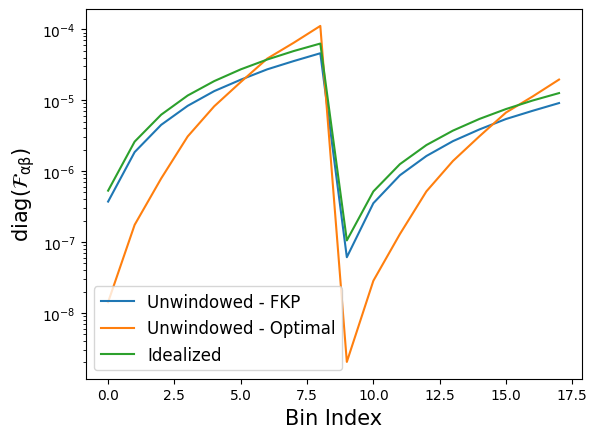

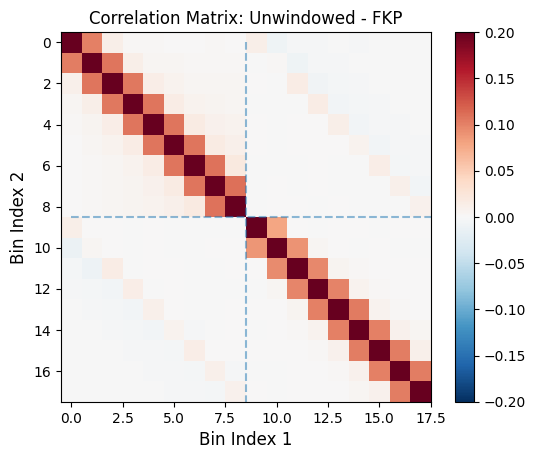

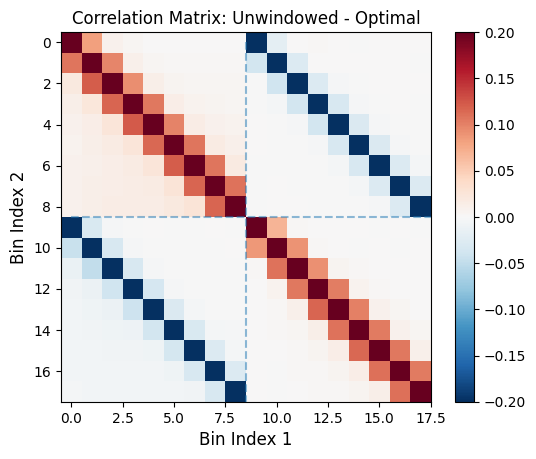

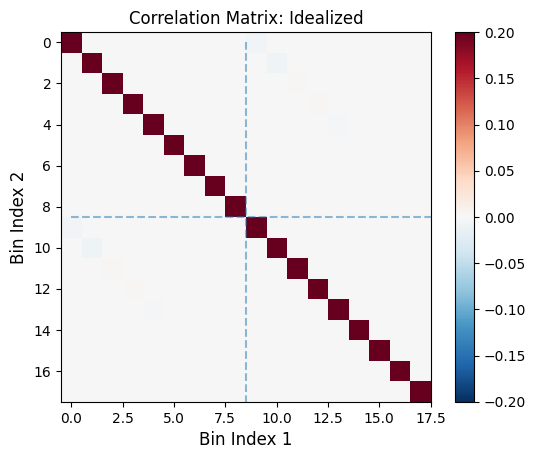

In [27]:
# Plot the diagonal
plt.plot(np.arange(len(fish)),np.diag(fish),label='Unwindowed - FKP')
plt.plot(np.arange(len(fish_opt)),np.diag(fish_opt),label='Unwindowed - Optimal')
plt.plot(np.diag(fish_ideal),label='Idealized')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$\rm{diag}(\mathcal{F}_{\alpha\beta})$',fontsize=15);
plt.legend(fontsize=12);
plt.yscale('log');

# Plot the correlation structure
plot_corr(fish,v=0.2,subtract_identity=False,title='Correlation Matrix: Unwindowed - FKP')
plot_corr(fish_opt,v=0.2,subtract_identity=False,title='Correlation Matrix: Unwindowed - Optimal')
plot_corr(fish_ideal,v=0.2,subtract_identity=False,title='Correlation Matrix: Idealized')

Next, we plot the power spectra themselves. These look very similar between the two sets of estimators, though there's some residual noise since we used a small number of Monte Carlo iterations. In general, the results should be consistent (the estimators are unbiased for all $\mathsf{S}^{-1}$ weightings), though we caution that the effects of leakage from unmeasured bins will differ. The optimal weightings typically offer slightly ($\sim 10\%$) improved signal-to-noise; this is difficult to estimate without a suite of simulations. 

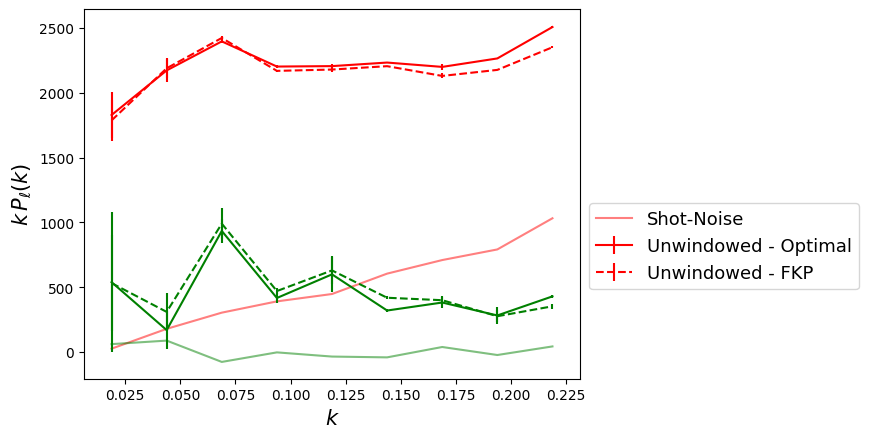

In [28]:
# Compute k 
k_cen = pspec_opt.get_ks()
dk = k_cen[1]-k_cen[0]

cs = {0:'r',2:'g',4:'blue'}
cs2 = {0:'darkred',2:'darkgreen',4:'darkblue'}

# Define shot-noise
Pk_shot = {'p%d'%l:pspec_opt.shot[l//2*pspec.Nk:(l//2+1)*pspec.Nk] for l in [0,2,4]}

# Plot spectra
plt.figure()
for li,l in enumerate([0,2]):
    plt.errorbar(k_cen, k_cen*Pk_unwindowed_opt['p%d'%l],yerr=k_cen*Pk_opt_err['p%d'%l],
                 c=cs[l],ls='-',label='Unwindowed - Optimal')
    plt.errorbar(k_cen, k_cen*Pk_unwindowed['p%d'%l],yerr=k_cen*Pk_err['p%d'%l],
                 c=cs[l],ls='--',label='Unwindowed - FKP')
    plt.plot(k_cen, k_cen*Pk_shot['p%d'%l],c=cs[l],ls='-',label='Shot-Noise',alpha=0.5)
    if li==0: plt.legend(fontsize=13,bbox_to_anchor=(1.,0.5))
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
dk = k_cen[1]-k_cen[0]
plt.xlim(k_cen[0]-dk/2,k_cen[-1]+dk/2);

As a test of our optimal weights, we can compute the Gaussian covariance matrix using the ```compute_covariance_contribution``` routine. If the weights are truly optimal, this will be equal to the inverse Fisher matrix. Here, we find great agreement (including for the monopole-quadrupole cross-correlation), validating our approach. 

In [29]:
# Iterate over realizations
covs_opt = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    cov_opt = pspec_opt.compute_covariance_contribution(1000+s,
                                                applySinv_transpose=applySinv_transpose_optimal,
                                                Pk_cov = [k_arr, P0_arr+r.attrs['shotnoise'], P2_arr], # power spectra including shot-noise
                                                verb=(s==1000))
    covs_opt.append(cov_opt)

# Assemble (unwindowed) covariance, including the necessary factors of F^{-1}
inv_fish_opt = np.linalg.inv(fish_opt)
cov_opt = inv_fish_opt@np.mean(covs_opt, axis=0)@inv_fish_opt.T

# Define the inverse-Fisher covariance
ideal_cov_opt = np.linalg.inv(fish_opt)

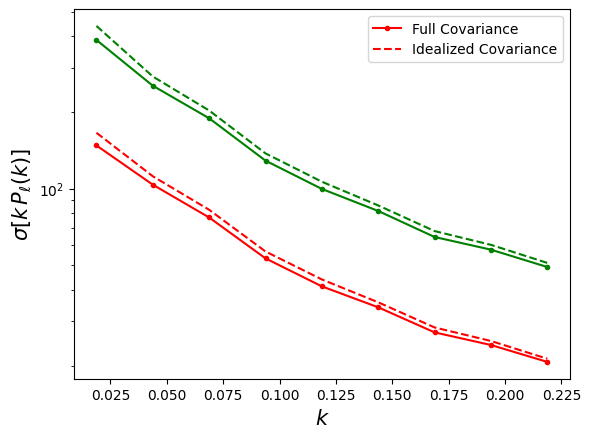

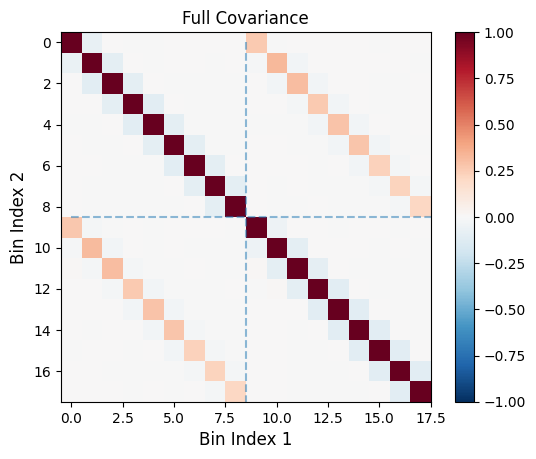

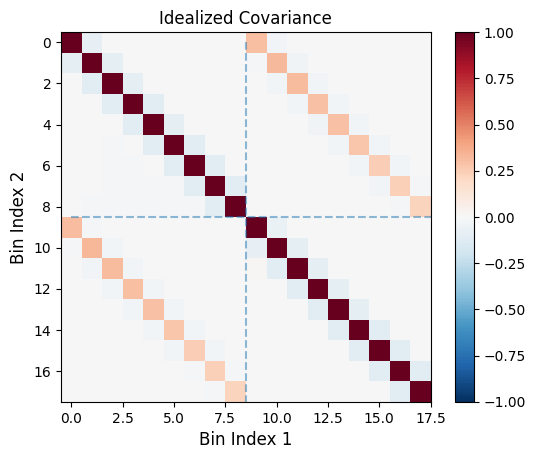

In [31]:
# Plot the variances
for li,l in enumerate([0,2]):
    plt.errorbar(k_cen, k_cen*np.sqrt(np.diag(cov_opt)[len(k_cen)*li:len(k_cen)*(li+1)]), c=cs[l],marker='.',label='Full Covariance')
    plt.errorbar(k_cen, k_cen*np.sqrt(np.diag(ideal_cov_opt)[len(k_cen)*li:len(k_cen)*(li+1)]),c=cs[l],ls='--',label='Idealized Covariance')
    if li==0: plt.legend();
plt.yscale('log')
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$\sigma[k\,P_\ell(k)]$',fontsize=15)

plot_corr(cov_opt,subtract_identity=False,title='Full Covariance')
plot_corr(ideal_cov_opt,subtract_identity=False,title='Idealized Covariance')

This completes the tutorial! In the remaining tutorials, we'll discuss how to compute bispectra with PolyBin3D!